In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from transformers import AutoTokenizer, DistilBertModel
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a simple torch model with 1 fully connected layer

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 2)

    def forward(self, x):
        # apply relu on the output of the fully connected layer
        # x = F.relu(self.fc1(x))
        x = self.fc1(x)
        return x

In [4]:
color_words = [
    'aqua', 'aquamarine', 'azure', 'beige', 'bisque',
    'chartreuse', 'chocolate', 'coral', 'crimson', 'cyan', 'firebrick', 'fuchsia',
    'gold', 'gray', 'indigo', 'ivory', 'khaki', 'lavender', 'lime', 'magenta',
    'maroon', 'navy', 'olive', 'orchid', 'plum', 
    'salmon', 'sienna', 'silver', 'tan', 'teal', 'tomato', 'turquoise', 
    'wheat', 'sienna', 'ochre', 'umber', 'sepia', 'vermillion',
    'carmine', 'cerulean', 'auburn', 'viridian', 'ultramarine', 'emerald'
]

most_common_color_words = [
    'red', 'green', 'blue', 'yellow', 'orange', 'purple', 'brown', 'pink', 'violet', 'white', 'black'
]

# remove duplicates
color_words = list(set(color_words))
most_common_color_words = list(set(most_common_color_words))

print(len(color_words))
print(len(most_common_color_words))

assert len(list(set(color_words + most_common_color_words))) == len(color_words) + len(most_common_color_words)

43
11


In [7]:
non_color_words = [
    "...", "acidity", "snowboard", "shipment", "containment", ":", "broccoli", "U.S.", "accessory", "zebra", "umbrella", "Securities",
    "Corp.", "``", "productivity", "flutter", "frisbee", "tennis racket", "trading", "--", ";", "drying", "softness", "suitcase",
    "parking meter", "haul", "buy", "bench", "refrigerator", "Soviets", "microwave", "aroma", "wine glass", "formality", "solitude", "Wa",
    "scissors", "thrill", "baseball glove", "sanitation", "gathering", "toaster", "bark", "skis", "oven", "flush", "peel", "Containers",
    "shoe", "conformity", "whom", "elegance", "surfboard", "scoop", "cutlery", "C$", "fasten", "prices", "sandwich", "poke", "largest",
    "glide", "container", "couch", "soar", "funds", "graze", "teddy bear", "who", "Who", "paper", "backpack", "slice", "hygiene", "brush",
    "indulgence", "excitement", "loneliness", "lamp", "cow", "mobility", "stride", "%", "descent", "traffic light", "was", "lie", "drainage",
    "toothbrush", "carrot", "banana", "etc.", ".", "lawyer", "laptop", "remote", "rinse", "Perestroika", "consume", "toast", "hug", "market",
    "`", "including", "fire hydrant", "carry", "crunch", "chill", "moo"
]

# remove duplicates
non_color_words = list(set(non_color_words))

print(len(non_color_words))


109


In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

In [9]:
# create a function that takes a list of words and returns a list of embeddings
def get_embeddings(words):
    embeddings = []

    for word in words:
        input_ids = torch.tensor(tokenizer.encode(word)).unsqueeze(0)
        outputs = model(input_ids)
        last_hidden_states = outputs[0]
        embeddings.append(torch.mean(last_hidden_states[0][1:-1], dim=0).tolist())
    
    assert len(embeddings) == len(words)
    return embeddings

color_embeddings = get_embeddings(color_words)
most_common_color_embeddings = get_embeddings(most_common_color_words)
non_color_embeddings = get_embeddings(non_color_words)

In [10]:
# slice the lists into training and test sets
color_words_train = color_words[:int(len(color_words)*0.8)]
color_words_test = color_words[int(len(color_words)*0.8):]
color_embeddings_train = color_embeddings[:int(len(color_embeddings)*0.8)]
color_embeddings_test = color_embeddings[int(len(color_embeddings)*0.8):]

most_common_color_words_train = most_common_color_words[:int(len(most_common_color_words)*0.8)]
most_common_color_words_test = most_common_color_words[int(len(most_common_color_words)*0.8):]
most_common_color_embeddings_train = most_common_color_embeddings[:int(len(most_common_color_embeddings)*0.8)]
most_common_color_embeddings_test = most_common_color_embeddings[int(len(most_common_color_embeddings)*0.8):]

non_color_words_train = non_color_words[:int(len(non_color_words)*0.8)]
non_color_words_test = non_color_words[int(len(non_color_words)*0.8):]
non_color_embeddings_train = non_color_embeddings[:int(len(non_color_embeddings)*0.8)]
non_color_embeddings_test = non_color_embeddings[int(len(non_color_embeddings)*0.8):]

# create a dataframe with the training sets
train_embeddings = color_embeddings_train + most_common_color_embeddings_train + non_color_embeddings_train
df_train = pd.DataFrame(train_embeddings)
# convert the column names to strings
df_train.columns = [str(i) for i in df_train.columns]

df_train['label'] = [1]*len(color_words_train) + [1]*len(most_common_color_words_train) + [0]*len(non_color_words_train)
df_train['word'] = color_words_train + most_common_color_words_train + non_color_words_train

# create a dataframe with the test sets
test_embeddings = color_embeddings_test + most_common_color_embeddings_test + non_color_embeddings_test
df_test = pd.DataFrame(test_embeddings)
# convert the column names to strings
df_test.columns = [str(i) for i in df_test.columns]

df_test['label'] = [1]*len(color_words_test) + [1]*len(most_common_color_words_test) + [0]*len(non_color_words_test)
df_test['word'] = color_words_test + most_common_color_words_test + non_color_words_test

# df_train = pd.DataFrame({
#     'word': color_words_train + most_common_color_words_train + non_color_words_train,
#     'embedding': color_embeddings_train + most_common_color_embeddings_train + non_color_embeddings_train,
#     'label': [1]*len(color_words_train) + [1]*len(most_common_color_words_train) + [0]*len(non_color_words_train)
# })

# df_test = pd.DataFrame({
#     'word': color_words_test + most_common_color_words_test + non_color_words_test,
#     'embedding': color_embeddings_test + most_common_color_embeddings_test + non_color_embeddings_test,
#     'label': [1]*len(color_words_test) + [1]*len(most_common_color_words_test) + [0]*len(non_color_words_test)
# })

# shuffle the dataframes
# df_train = df_train.sample(frac=1).reset_index(drop=True)
# df_test = df_test.sample(frac=1).reset_index(drop=True)

print(df_train[:5])
print(df_train[-5:])
print(df_test[:5])
print(df_test[-5:])

          0         1         2         3         4         5         6  \
0 -0.164306  0.236645 -0.328378 -0.170503  0.590267  0.298811 -0.097471   
1  0.125199  0.227860 -0.366152 -0.002999  0.656822  0.120573  0.118489   
2 -0.041678  0.148708 -0.234286 -0.033252  0.494860  0.622115  0.000841   
3  0.308206  0.380914 -0.145341  0.033035  0.216088 -0.055953  0.397435   
4  0.242734 -0.032436 -0.144375 -0.357046  0.275547  0.518408  0.114429   

          7         8         9  ...       760       761       762       763  \
0  0.248777  0.215423 -0.359507  ...  0.155917 -0.005785  0.234874 -0.098209   
1  0.036798  0.533373 -0.229624  ...  0.025945 -0.349541  0.203456 -0.089264   
2  0.334732 -0.142980 -0.213030  ... -0.058299 -0.062284  0.417793 -0.012300   
3  0.486138 -0.087859 -0.435906  ...  0.249578 -0.232039  0.482491  0.088134   
4 -0.048240 -0.216223 -0.843553  ...  0.393864  0.047029  0.359514 -0.004629   

        764       765       766       767  label     word  
0 -0.066

In [11]:
class CustomDataset(Dataset):
    def __init__(self, tokenized_texts, labels):
        self.tokenized_texts = torch.tensor(tokenized_texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.tokenized_texts[idx], self.labels[idx]

In [12]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps')
device = torch.device('cpu')

In [13]:
def create_dataloaders(df_train, df_test):
  train_dataset = CustomDataset(df_train['embedding'], df_train['label'])
  test_dataset = CustomDataset(df_test['embedding'], df_test['label'])

  train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

  return train_loader, test_loader

In [14]:
def train_model(train_loader):

    # train the model
    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.003)

    num_epochs = 100
    net.to(device)

    best_combined_loss = float('inf')

    for epoch in range(num_epochs):
        net.train()
        combined_loss = 0
        for batch in train_loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            data = data.unsqueeze(1)
            targets = batch[1].to(device=device)
            # print(data.shape)
            
            # forward
            scores = net(data)
            loss = criterion(scores, targets)
            combined_loss += loss.item()

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent or adam step
            optimizer.step()

        if combined_loss < best_combined_loss:
            best_combined_loss = combined_loss
        
        # print initial loss
        # if epoch == 0:
        #     print(f'Initial loss: {combined_loss/len(train_loader)}')
            
        # print average loss per epoch every 10 epochs
        # if (epoch + 1) % 10 == 0:
        #     print(f'Epoch {epoch + 1}, loss={combined_loss/len(train_loader)}')
        #     # print(combined_loss / len(train_loader))

    return net, best_combined_loss



In [15]:
# evaluate the net
def check_accuracy(loader, net):
    num_correct = 0
    num_samples = 0
    net.eval()

    with torch.no_grad():
        for batch in loader:
            # get data to GPU if possible
            data = batch[0].to(device=device, dtype=torch.float32)
            data = data.unsqueeze(1)
            targets = batch[1].to(device=device)

            # forward
            scores = net(data)
            _, predictions = scores.max(1)
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
    
    return num_correct / num_samples

In [16]:
# go through all the slices of the dataframe and train and evaluate the model

all_test_accs = []
all_combined_losses = []

# for slice in range(768):
slice = 588

print(f'Slice: {slice}')
# slice = 0

# create one column slice of the dataframe
df_train_slice = pd.DataFrame({
    # 'word': df_train['word'],
    'embedding': df_train[str(slice)],
    'label': df_train['label']
})

df_test_slice = pd.DataFrame({
    # 'word': df_test['word'],
    'embedding': df_test[str(slice)],
    'label': df_test['label']
})

# print(df_train_slice[:5])
# print(df_train_slice[-5:])

train_slice_loader, test_slice_loader = create_dataloaders(df_train_slice, df_test_slice)

# take the best of 3 runs
best_test_acc = 0

for i in range(10):
    net, best_combined_loss = train_model(train_slice_loader)

    train_acc = check_accuracy(train_slice_loader, net)
    test_acc = check_accuracy(test_slice_loader, net)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        # best_train_acc = train_acc
        # best_net = net

all_test_accs.append(best_test_acc)
all_combined_losses.append(best_combined_loss)

# print(f'Accuracy on training set: {check_accuracy(train_loader, net)*100:.2f}%')
# print(f'Accuracy on test set: {check_accuracy(test_loader, net)*100:.2f}%')

print(f'Slice {slice} best combined loss: {best_combined_loss}')
print(f'Slice {slice} best test accuracy: {best_test_acc*100:.2f}% \n')

print(len(all_test_accs))

Slice: 588
Slice 588 best combined loss: 5.256365716457367
Slice 588 best test accuracy: 64.71% 

1


In [17]:
print(all_test_accs[:10]) 

[tensor(0.6471)]


In [18]:
# convert list of tensors into list of floats
all_test_accs_val = [acc.item() for acc in all_test_accs]

print(all_test_accs_val[:10])

[0.6470588445663452]


In [19]:
all_test_accs_val = np.array(all_test_accs_val)
all_combined_losses = np.array(all_combined_losses)

In [20]:
# find the indices of the top 10 slices
top_10_indices = np.argsort(all_test_accs_val)[-10:]
print(top_10_indices)
print(all_test_accs_val[top_10_indices])
print(all_combined_losses[top_10_indices])

[0]
[0.64705884]
[5.25636572]


In [21]:
# create a dataframe with accuracy and loss
df_acc_loss = pd.DataFrame({
    'accuracy': all_test_accs_val,
    'loss': all_combined_losses
})

print(df_acc_loss[:10])

# save the dataframe to a csv file
# df_acc_loss.to_csv('llm-outputs/color_xl_bruteforce_acc_loss.csv', index=False)

   accuracy      loss
0  0.647059  5.256366


In [22]:
# for each of the top 10 slices,
# average the embeddings of the color words and the non-color words

color_emb_avg = []
non_color_emb_avg = []

for i in top_10_indices:
    df_slice = pd.DataFrame({
        'word': df_train['word'],
        'embedding': df_train[str(i)],
        'label': df_train['label']
    })

    df_slice_color = df_slice[df_slice['label'] == 1]
    df_slice_non_color = df_slice[df_slice['label'] == 0]

    color_emb_avg.append(np.mean(df_slice_color['embedding']))
    non_color_emb_avg.append(np.mean(df_slice_non_color['embedding']))

# create a dataframe with the average embeddings
df_avg = pd.DataFrame({
    'index': top_10_indices,
    'color': color_emb_avg,
    'non_color': non_color_emb_avg,
    'diff': abs(np.array(color_emb_avg) - np.array(non_color_emb_avg)),
    'acc': all_test_accs_val[top_10_indices],
    'loss': all_combined_losses[top_10_indices]
})

print(df_avg)

# save the dataframe to a csv file
# df_avg.to_csv('llm-outputs/color_xl_bruteforce_avg.csv', index=False)

   index     color  non_color      diff       acc      loss
0      0  0.042866   0.154596  0.111729  0.647059  5.256366


In [23]:
# add words to df_train_slice
df_train_slice['word'] = df_train['word']

# save the dataframe to a csv file
df_train_slice.to_csv('llm-outputs/color_xl_bruteforce_slice_588.csv', index=False)

In [24]:
def plot_axis_hist(slice):
    df_slice = pd.DataFrame({
        # 'word': df_train['word'],
        'embedding': df_train[str(slice)],
        'label': df_train['label']
    })

    df_slice_color = df_slice[df_slice['label'] == 1]
    df_slice_non_color = df_slice[df_slice['label'] == 0]

    # draw a histogram of the embeddings, with the color words in red and the non-color words in blue
    plt.hist(df_slice_color['embedding'], bins=30, color='red', alpha=0.5)
    plt.hist(df_slice_non_color['embedding'], bins=30, color='blue', alpha=0.5)
    plt.show()

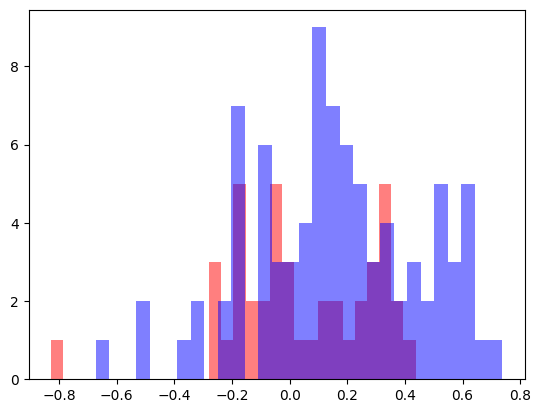

In [25]:
plot_axis_hist(0)